#### Helper functions

In [1]:
import os


class ByteArray:
    
    def __init__(self, data):
        self.seek = 0
        self.data = data
    
    def eof(self):
        return self.seek >= len(self.data)
    
    def validate_header(self):
        header = self.read_raw(4)
        if header != b'ANM\x02':
            raise Exception('Unexpected header: ' + str(header))

        header2 = self.read_short()
        if header2 != 0:
            raise Exception('Unexpected header2: ' + str(header2))
    
    def read_byte(self):
        val = self.data[self.seek]
        self.seek += 1
        return val
    
    def read_short(self):
        val = self.data[self.seek] + self.data[self.seek+1] * 0x100
        self.seek += 2
        return val
    
    def read_signed_short(self):
        val = self.read_short()
        if val >= 2**15:
            val -= 2**16
        return val
    
    def read_raw(self, n):
        val = self.data[self.seek:self.seek+n]
        self.seek += n
        return val
    
    def skip(self, n):
        self.seek += n


def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def chunk_hex(byte_arr):
    return ' '.join(chunks(''.join([f'{b:02X}' for b in byte_arr]), 4))

#### Main

In [2]:
rootdir = '/Users/wasd/Downloads/Mall Maniacs/anim/'

In [3]:
def parse_to_keyframes(data):
    buf = ByteArray(data)
    buf.validate_header()
    
    num_crap_strings = buf.read_short()
    for _ in range(num_crap_strings):
        crap_length = buf.read_byte()
        buf.skip(crap_length+2)
    
    num_keyframes = buf.read_short()
    keyframes = []
    for _ in range(num_keyframes - 1):
        num_entries = buf.read_short()
        entries = []
        for _ in range(num_entries):
            entry_type = buf.read_byte()
            if entry_type == 5:
                raw = buf.read_raw(8)
            elif entry_type == 6:
                raw = buf.read_raw(14)
            else:
                raise Exception('Not yet implemented entry_type: ' + str(entry_type))

            entries.append((entry_type, raw))

        keyframes.append(entries)
    return keyframes

In [4]:
file2keyframes = {}
for file in os.listdir(rootdir):
    if not file.endswith('.anm'):
        continue
    
    with open(rootdir + file, 'rb') as f:
        data = f.read()
    
    file2keyframes[file] = parse_to_keyframes(data)

In [5]:
print(file2keyframes.keys())

dict_keys(['s_flpick1.anm', 's_winner.anm', 's_flpick2.anm', 's_pick.anm', 's_fl_pick1.anm', 's_fl_pick2.anm', 's_oops.anm', 'cash_sit.anm', 's_stand2.anm', 'stand.anm', 's_grab.anm', 's_clap.anm', 's_throw2.anm', 's_throw1.anm', 's_stand.anm', 's_pick1.anm', 's_loser.anm', 's_run.anm', 's_pick2.anm'])


In [6]:
def pretty_print(keyframes):
    for entries in keyframes:
        for e, arr in entries:
            print(f'{e:02d} {chunk_hex(arr)}')
        print()

In [7]:
pretty_print(file2keyframes['s_stand.anm'])

05 0600 E7ED 4EC4 3D07
05 0700 F715 4F0B 2BF0
05 0800 B6ED C61D 480C
06 0000 0000 0000 5103 0000 7700 0000
05 0000 30FF 0000 0000
05 0100 0000 0000 0000
05 0200 0000 0000 0000
05 0900 0000 0000 0000
05 0A00 0000 0000 0000
05 0B00 0000 0000 0000
05 0C00 0000 0000 0000
05 0300 2AED F03C 42F8
05 0400 3914 2EF6 CA13
05 0500 16F3 55DC 75EC
05 0D00 0000 0000 0000
05 0E00 0000 0000 0000
05 0F00 0000 0000 0000


05 0100 2F00 0A00 0B00
05 0200 9EFF B2FF D1FF

05 0100 6300 1700 1800
05 0200 31FF 5CFF 9DFF

05 0100 9B00 2400 2600
05 0200 BEFE 03FF 69FF

05 0100 D600 3200 3500
05 0200 48FE AAFE 36FF

05 0100 1401 4100 4400
05 0200 D1FD 53FE 06FF

05 0100 5201 5000 5400
05 0200 5DFD 03FE DBFE

05 0100 9101 6000 6500
05 0200 F0FC BDFD B5FE

05 0100 CF01 6F00 7500
05 0200 8EFC 82FD 96FE

05 0100 0B02 7E00 8500
05 0200 3AFC 56FD 7FFE

05 0100 4502 8D00 9500
05 0200 ECFB 36FD 6FFE

05 0100 7B02 9B00 A400
05 0200 A0FB 20FD 63FE

05 0100 AD02 A800 B200
05 0200 57FB 11FD 5BFE

05 0100 DA02 B400 BE00
05 02

#### Plot stand

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def plot_keyframes(filename, vector_group_key):
    entries = [b for frame in file2keyframes[filename] for _,b in frame if b[0:2] == vector_group_key]
    xyz = []
    
    for entry in entries:
        buf = ByteArray(entry)
        buf.read_signed_short()
        xyz.append((buf.read_signed_short(), buf.read_signed_short(), buf.read_signed_short()))
    xyz = np.array(xyz)
    
    plt.plot(xyz[:, 0])
    plt.plot(xyz[:, 1])
    plt.plot(xyz[:, 2])
    plt.show()

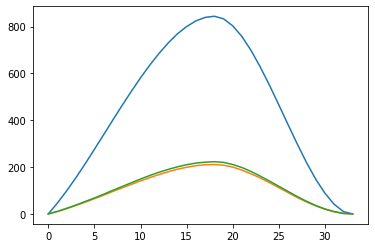

In [16]:
plot_keyframes('s_stand.anm', b'\x01\x00')

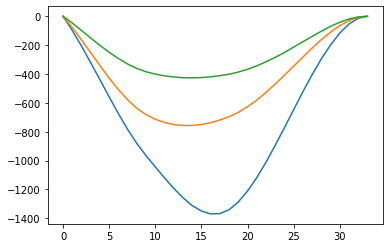

In [17]:
plot_keyframes('s_stand.anm', b'\x02\x00')